In [1]:
import numpy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.math.toccd import toccd

from ekarus.e2e.devices.pyr3_wfs import Pyr3WFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer
# from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

from  ekarus.e2e.utils.image_utils import get_photocenter#, image_grid


[XuPy] GPU Acceleration not available. 
       Fallback to NumPy instead.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator

def create_field_from_zernike_coefficients(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return mask.asTransmissionValue() * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    zg = ZernikeGenerator(mask)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * zg.getZernike(noll)
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.mask().shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * zg.getZernike(noll)

    return zern

In [3]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

def tilt_field(pyr, field, tiltAmpX, tiltAmpY):
    tiltX,tiltY = pyr._get_XY_tilt_planes(field.shape)
    wedge_tilt = (tiltX*tiltAmpX + tiltY*tiltAmpY)*(2*xp.pi)#*pyr.oversampling
    focal_plane_field = xp.fft.fftshift(xp.fft.fft2(field))
    field = focal_plane_field * xp.exp(1j*wedge_tilt)#, dtype=pyr.cdtype)
    field = xp.fft.ifft2(xp.fft.ifftshift(field))
    return field

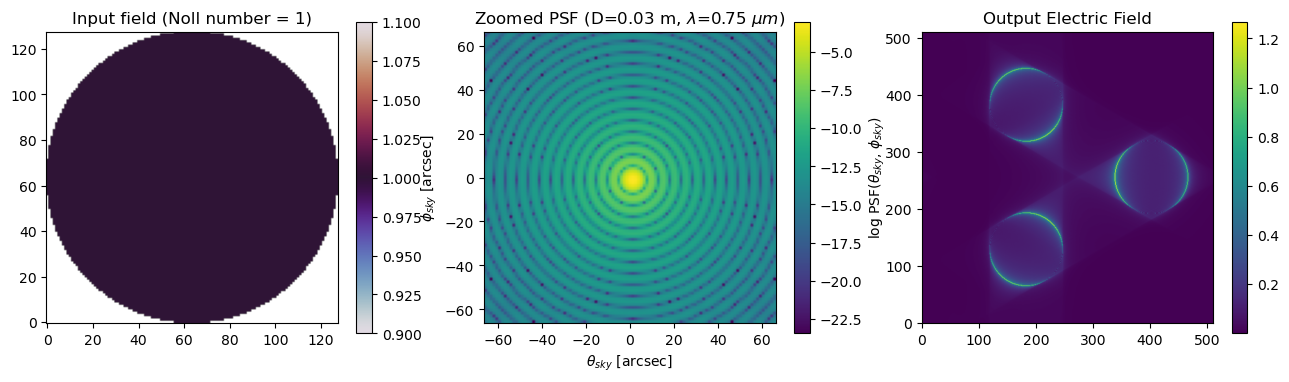

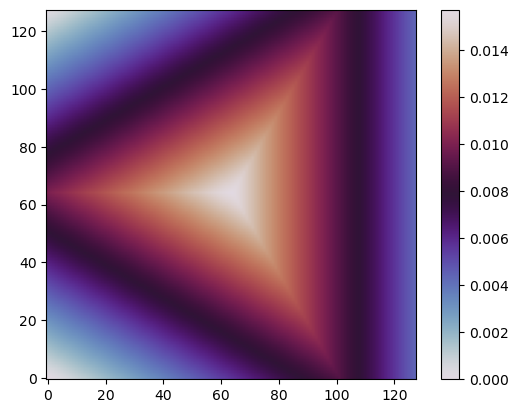

In [4]:
Npix = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 750e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec
lambdaOverD = lambdaInM/pupilDiameterInM

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Pyramid WFS
apex_angle = 100*(2*xp.pi)*lambdaOverD
wfs = Pyr3WFS(apex_angle, oversampling, sensorLambda=lambdaInM)

# Electric field propagation
padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
output_field = wfs.propagate(padded_field, lambdaOverD)
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(16,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(xp.angle(input_field), cmap='twilight', origin='lower')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)


plt.subplot(1, 3, 3)
plt.title("Output Electric Field")
plt.imshow(intensity,origin='lower')
plt.colorbar(shrink=s)
plt.show()

plt.figure()
plt.imshow(wfs.pyr3_phase_delay((Npix,Npix)),origin='lower',cmap='twilight')
plt.colorbar()

Modulating 10 [lambda/D] with 68 modulation steps
182.81683255835313 126.6957319952319 146.31330938298044
182.81683255835313 129.30426800476812 146.31330938298044
145.1375639566343 255.99999999999997 145.1375639566343


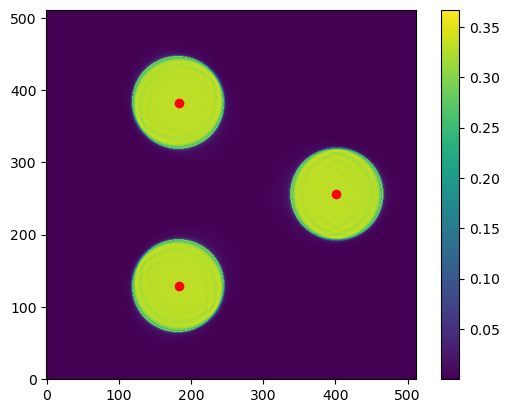

In [5]:
padded_field = xp.pad(mask.asTransmissionValue(), int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
wfs.set_modulation_angle(modulationAngleInLambdaOverD=10)
modulated_intensity = wfs.modulate(padded_field, lambdaOverD)

plt.figure()
plt.imshow(modulated_intensity,origin='lower')
plt.colorbar()

cx = (Npix*oversampling)//2
cy = (Npix*oversampling)//2

ul_intensity = modulated_intensity[int(cx):,:int(cy)]
qx,qy = get_photocenter(ul_intensity)
plt.scatter(qx,qy+cy,c='red')
print(qx,qy,xp.sqrt(abs(qx-cx)**2+abs(qy)**2))
ul_intensity = modulated_intensity[:int(cx),:int(cy)]
qx,qy = get_photocenter(ul_intensity)
plt.scatter(qx,qy,c='red')
print(qx,qy,xp.sqrt(abs(qx-cx)**2+abs(qy-cy)**2))
ul_intensity = modulated_intensity[:,int(cy):]
qx,qy = get_photocenter(ul_intensity)
plt.scatter(qx+cx,qy,c='red')
print(qx,qy,xp.sqrt(abs(qx)**2+abs(qy-cy)**2))

In [6]:
detector_shape = (256,256)#(64,64)
ccd = Detector(detector_shape=detector_shape)

Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps


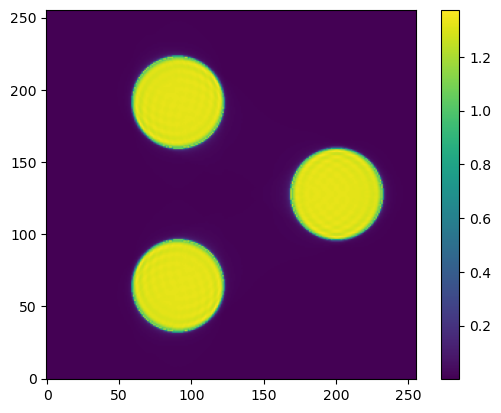

In [7]:
pars = {'modulationInLambdaOverD':3}

sc = SlopeComputer(wfs, ccd, pars)
sc.calibrate_sensor(tn='', prefix_str='', recompute=True, piston=mask.asTransmissionValue(), lambdaOverD=lambdaOverD, Npix=63, centerObscurationInPixels=0.0)
subapertures = sc._subaperture_masks

ccd_modulated_intensity = ccd.last_frame #toccd(modulated_intensity,ccd.detector_shape)

plt.figure()
plt.imshow(ccd_modulated_intensity, origin='lower')
plt.colorbar()

Modulating 3 [lambda/D] with 20 modulation steps
3


Text(0.5, 1.0, 'Masked Intensity C')

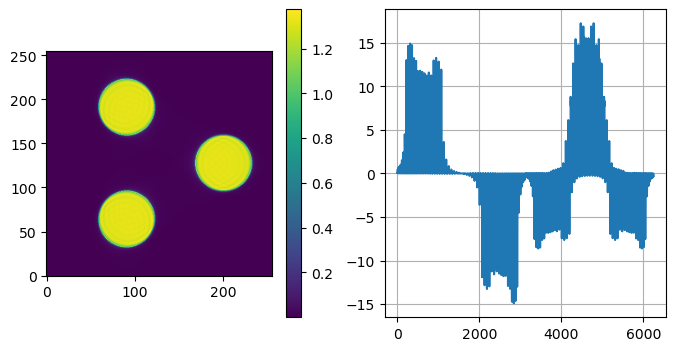

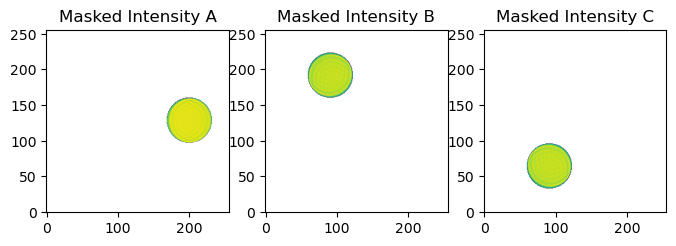

In [8]:
wfs.set_modulation_angle(modulationAngleInLambdaOverD=3)
print(wfs.modulationAngleInLambdaOverD)
slope = sc.compute_slopes(ccd_modulated_intensity, lambdaOverD, nPhotons=None)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(ccd_modulated_intensity, origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(slope)
plt.grid()

plt.figure(figsize=(8,8))
plt.subplot(1,3, 1)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subapertures[0]), origin='lower')
plt.title("Masked Intensity A")
plt.subplot(1,3, 2)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subapertures[1]), origin='lower')
plt.title("Masked Intensity B")
plt.subplot(1,3, 3)
plt.imshow(masked_array(ccd_modulated_intensity, mask=subapertures[2]), origin='lower')
plt.title("Masked Intensity C")

In [10]:
# Compute slopes for Zernike modes
N = 9
Nmodes = (N-1)*(N-2)//2
IM = xp.zeros((int(xp.size(slope)),Nmodes))
Npix = 128
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

rms_vec = xp.zeros(Nmodes)
zern_amp = 0.1
N0 = 2

for i in range(Nmodes):

    noll = N0 + i
    input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
    rms_vec[i] = xp.std(xp.angle(input_zern[~mask.mask()]))

    # padded_zern = xp.pad(input_zern, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
    # modulated_intensity = wfs.modulate(padded_zern, lambdaOverD)
    # zern_slopes = sc.compute_slopes(modulated_intensity, lambdaOverD, nPhotons=None, use_diagonal=False)
    zern_slopes = sc.compute_slopes(input_zern, lambdaOverD, nPhotons=None)

    # intensity = wfs.propagate(input_zern)
    # zern_slopes = ccd.compute_slopes(xp.abs(intensity**2))

    IM[:,i] = zern_slopes/zern_amp

U,S,V = xp.linalg.svd(IM, full_matrices=False)

Sinv = 1/S
Rec = (V.T * Sinv) @ U.T

Text(0.5, 1.0, 'Measured intensity')

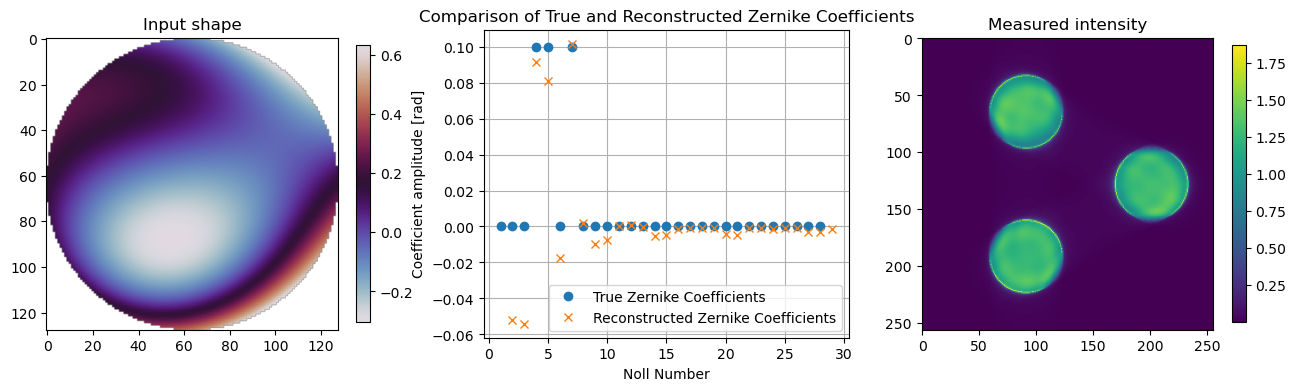

In [ ]:
# Test the reconstructor
zids = (4,5,7)
zamps = 0.1
zern_mix = create_field_from_zernike_coefficients(mask, zids, zamps)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(xp.ma.masked_array(xp.angle(zern_mix),mask=mask.mask()), cmap='twilight')
plt.colorbar(shrink=0.9)
plt.title('Input shape')

# Propagate the field through the WFS
# output_field = wfs.propagate(zern_mix/pix2rad)
# output_intensity = xp.abs(output_field**2)

# Compute slopes
slopes = sc.compute_slopes(zern_mix, lambdaOverD, nPhotons=None, method='slopes')
output_intensity = ccd.last_frame

# Reconstruct the Zernike coefficients
zern_reconstructed = Rec @ slopes
rec_noll_ids = xp.arange(Nmodes)+N0

noll_ids = xp.arange(Nmodes)+1
true_zern = xp.zeros(Nmodes)
true_zern[xp.array(zids)-1] = zamps

plt.subplot(1,3,2)
plt.plot(noll_ids, true_zern, 'o', label='True Zernike Coefficients')
plt.plot(rec_noll_ids, zern_reconstructed, 'x', label='Reconstructed Zernike Coefficients')
plt.xlabel('Noll Number')
plt.ylabel('Coefficient amplitude [rad]')
plt.title('Comparison of True and Reconstructed Zernike Coefficients')
plt.legend(loc='best')
plt.grid()

ccd_intensity = toccd(output_intensity, ccd.detector_shape)

plt.subplot(1,3,3)
plt.imshow(ccd_intensity,origin='lower')
plt.colorbar(shrink=0.9)
plt.title('Measured intensity')

In [14]:
def push_pull_calibrate(Nmodes, method:str='slopes', amp:float = 0.1):
    
    match method:
        case 'slopes':
            Ns = 2
        case 'all_slopes':
            Ns = 3
        case 'raw_intensity':
            Ns = 3
    
    slope_len = int(xp.sum(1-sc._subaperture_masks[0])*Ns)
    IM = xp.zeros((slope_len,Nmodes))
    nx = 128
    mask = CircularMask((nx,nx), maskRadius=nx // 2)

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        push_slope = sc.compute_slopes(input_zern, lambdaOverD, nPhotons=None, method=method)/amp

        input_zern = xp.conj(input_zern)
        pull_slope = sc.compute_slopes(input_zern, lambdaOverD, nPhotons=None, method=method)/amp

        plt.figure(figsize=(18,5))
        plt.subplot(1,3,1)
        plt.plot(push_slope)
        plt.grid()
        plt.subplot(1,3,2)
        plt.plot(pull_slope)
        plt.title(f'Noll {noll}')
        plt.grid()
        plt.subplot(1,3,3)
        plt.plot((push_slope-pull_slope)/2)
        plt.grid()

        IM[:,i] = (push_slope-pull_slope)/2

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

Modulating 3 [lambda/D] with 20 modulation steps


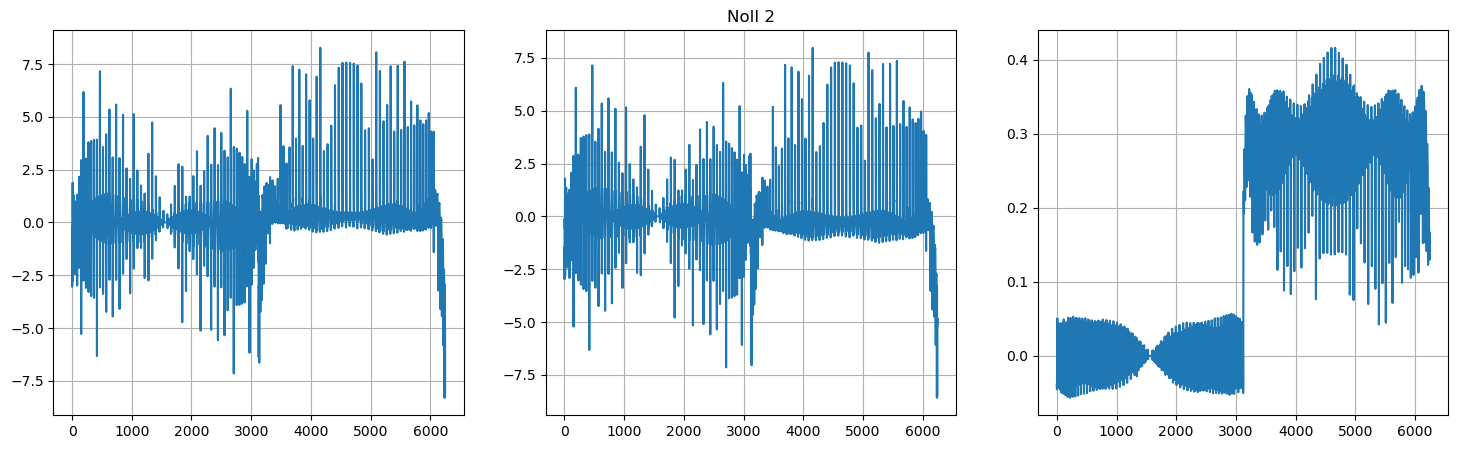

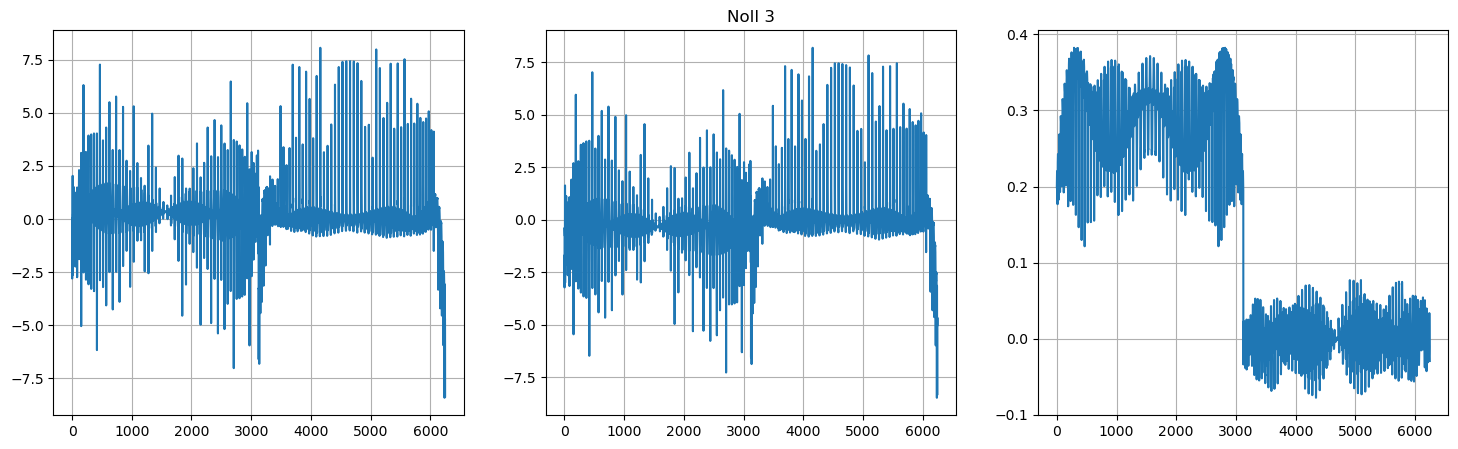

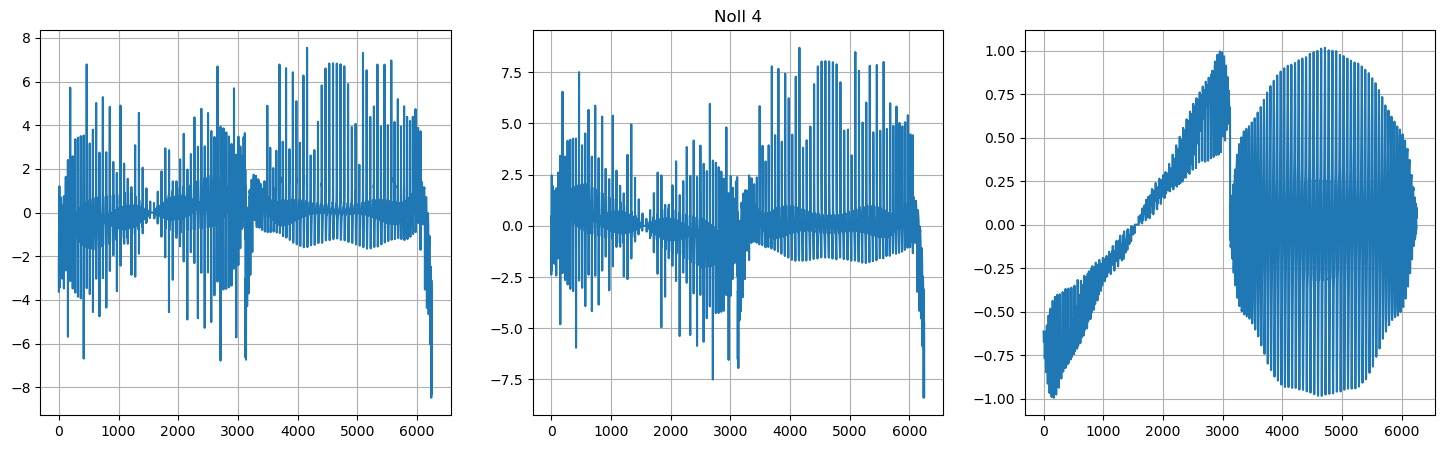

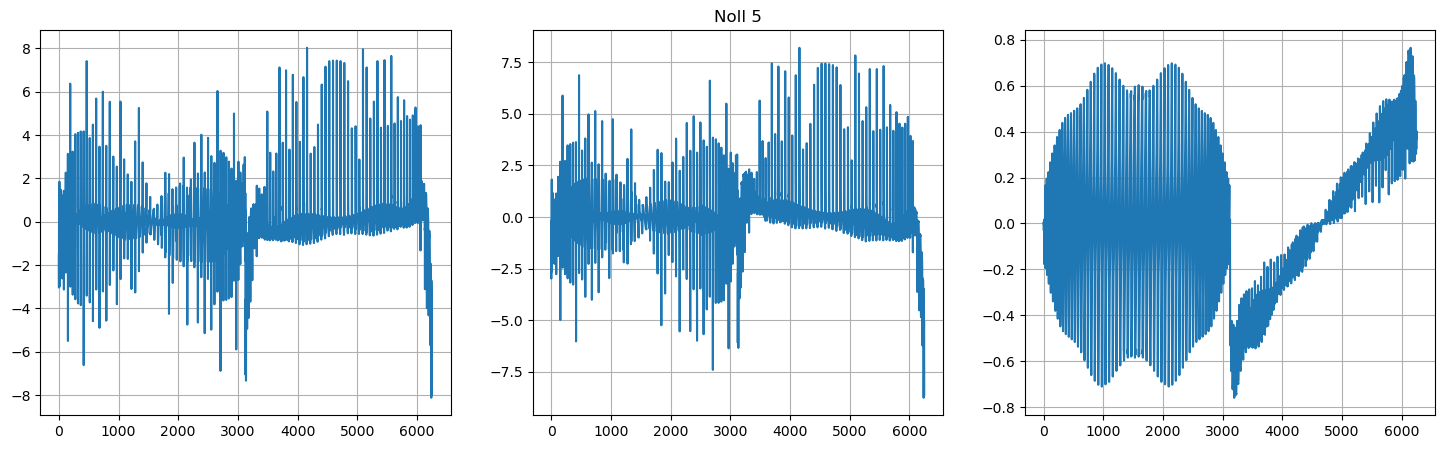

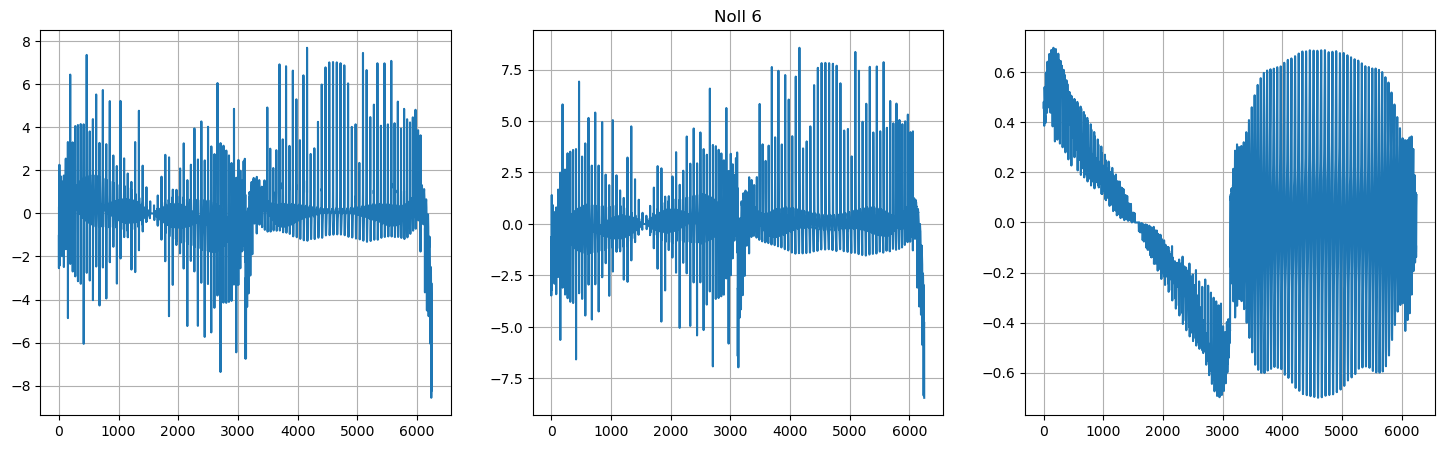

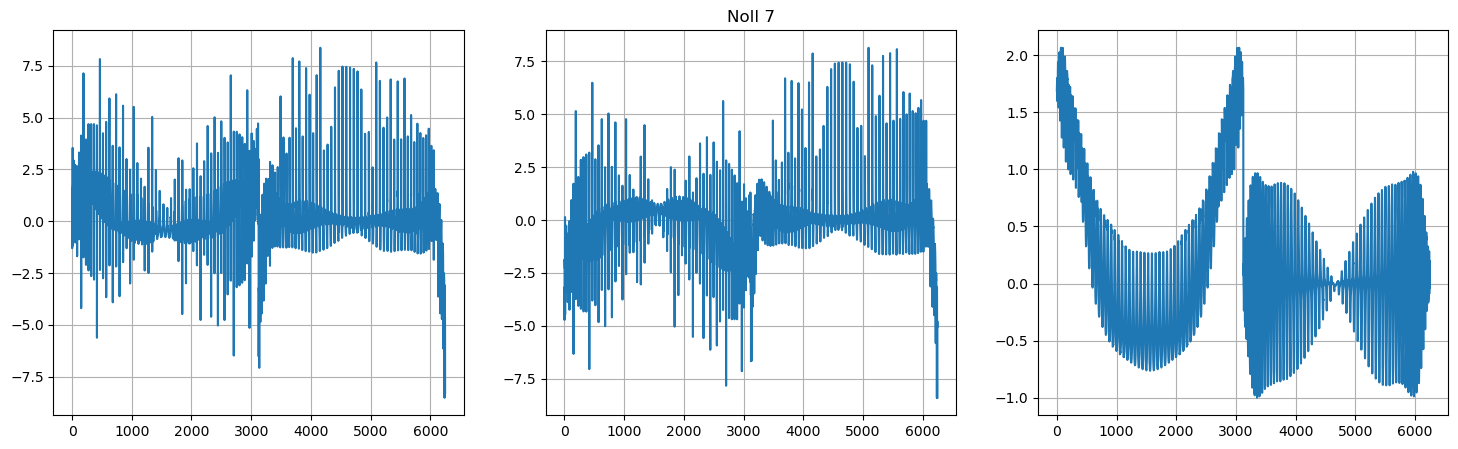

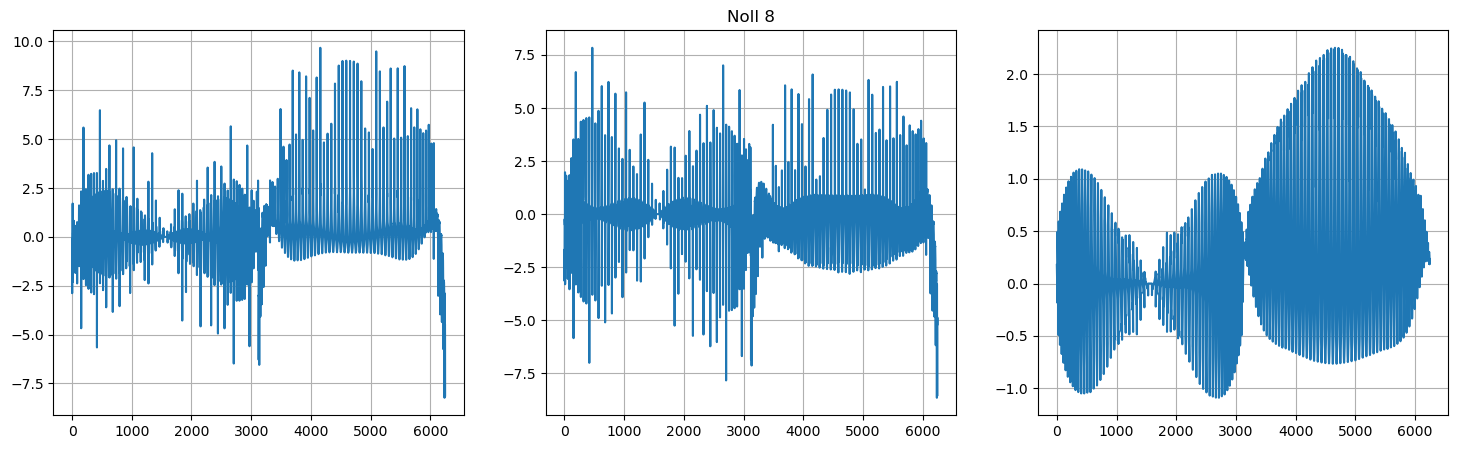

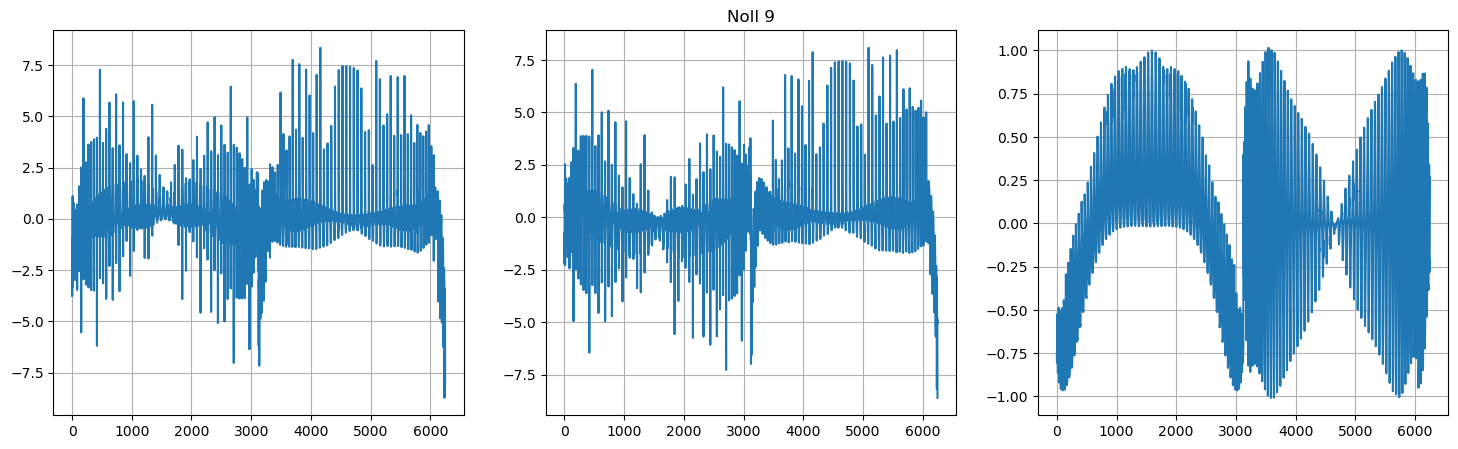

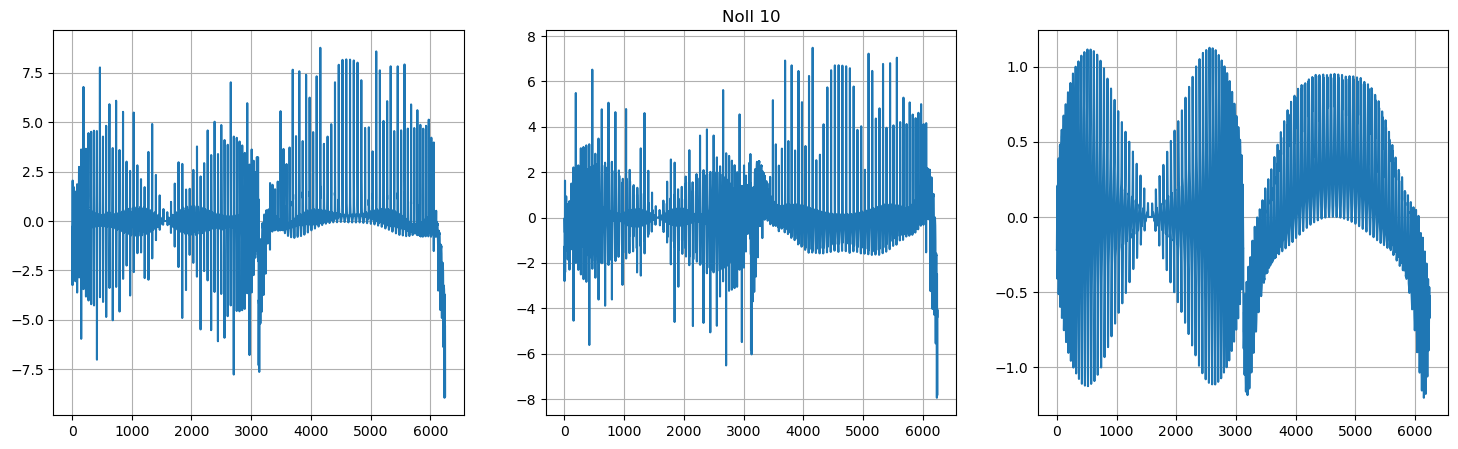

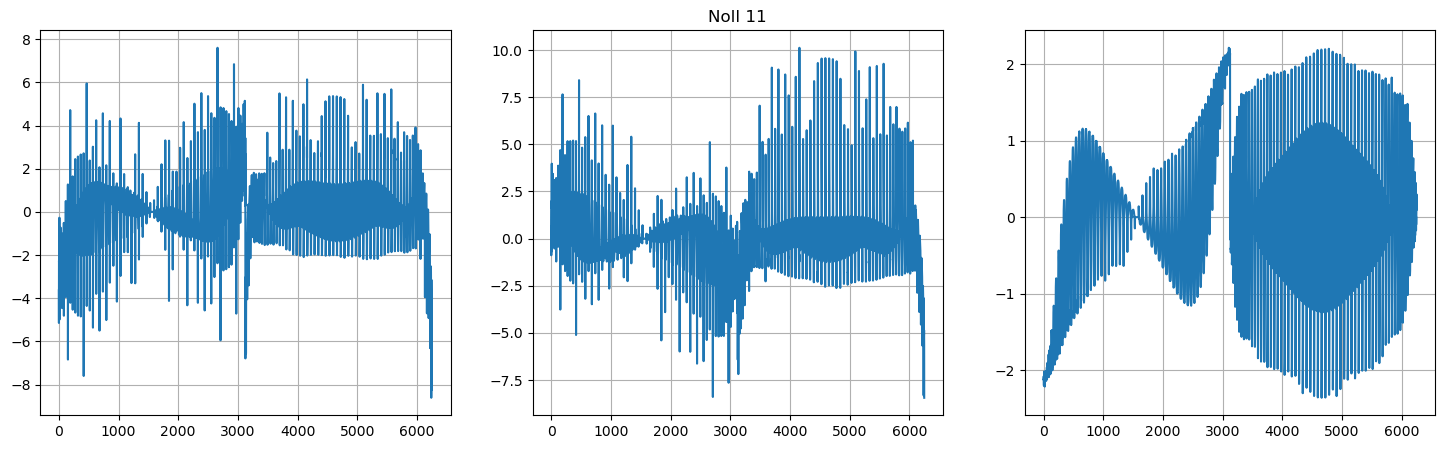

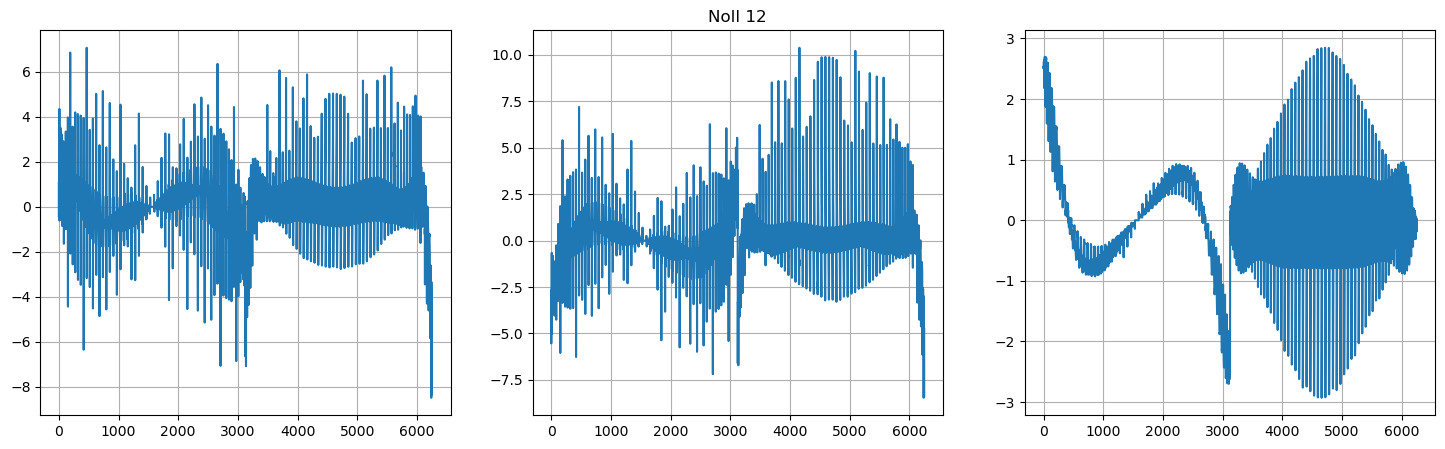

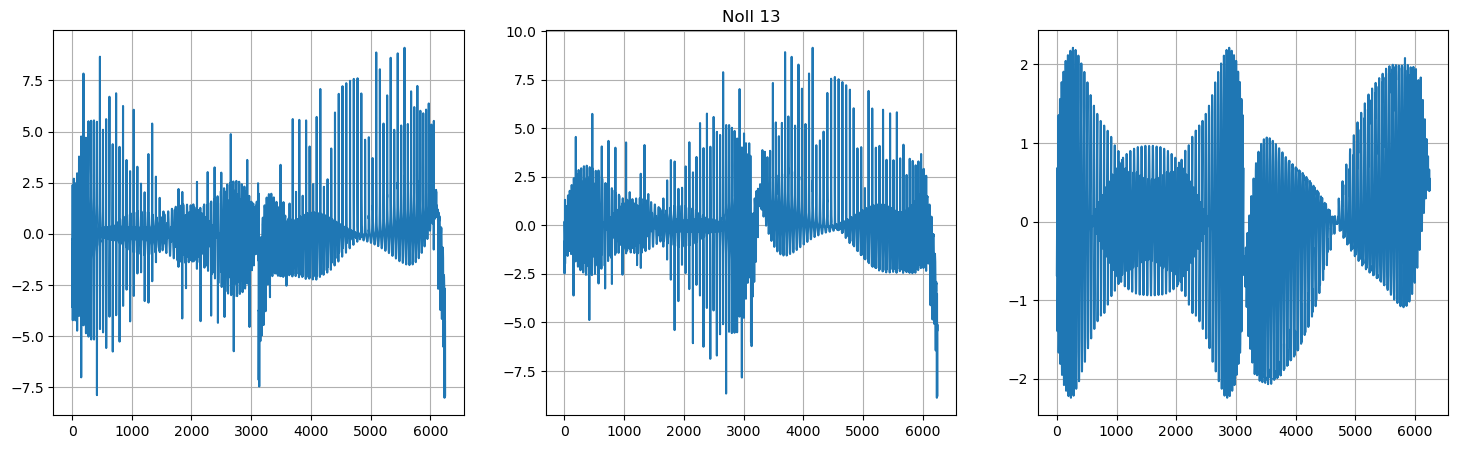

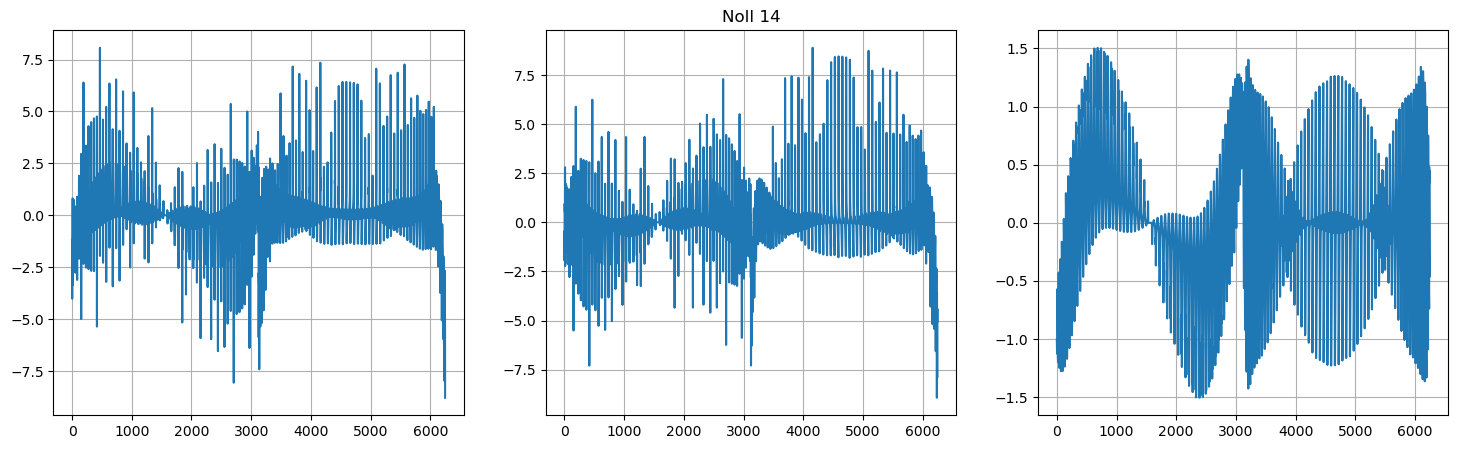

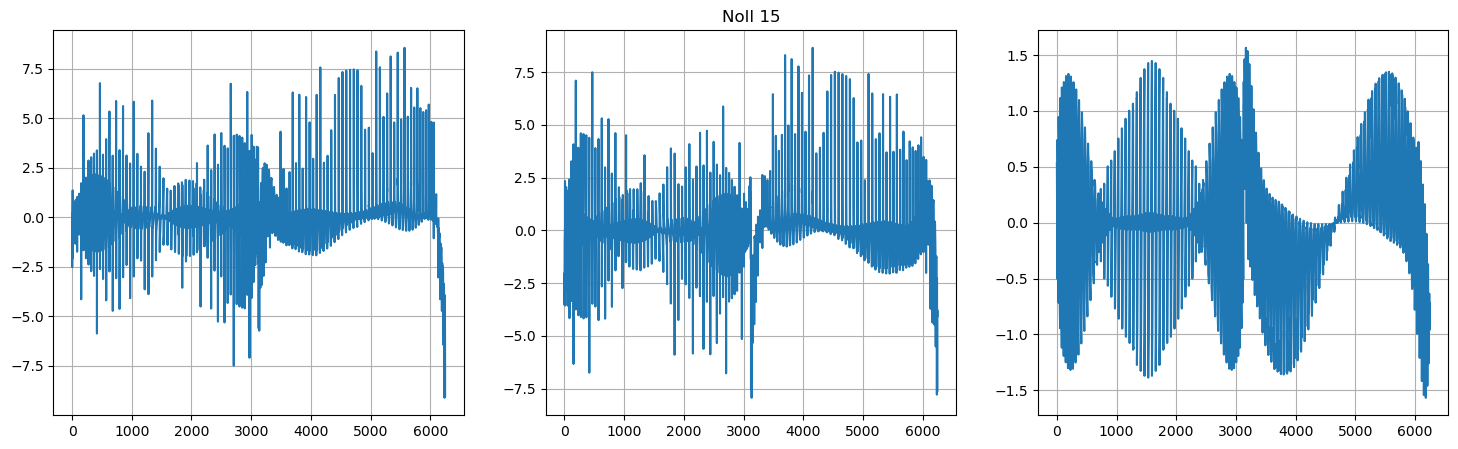

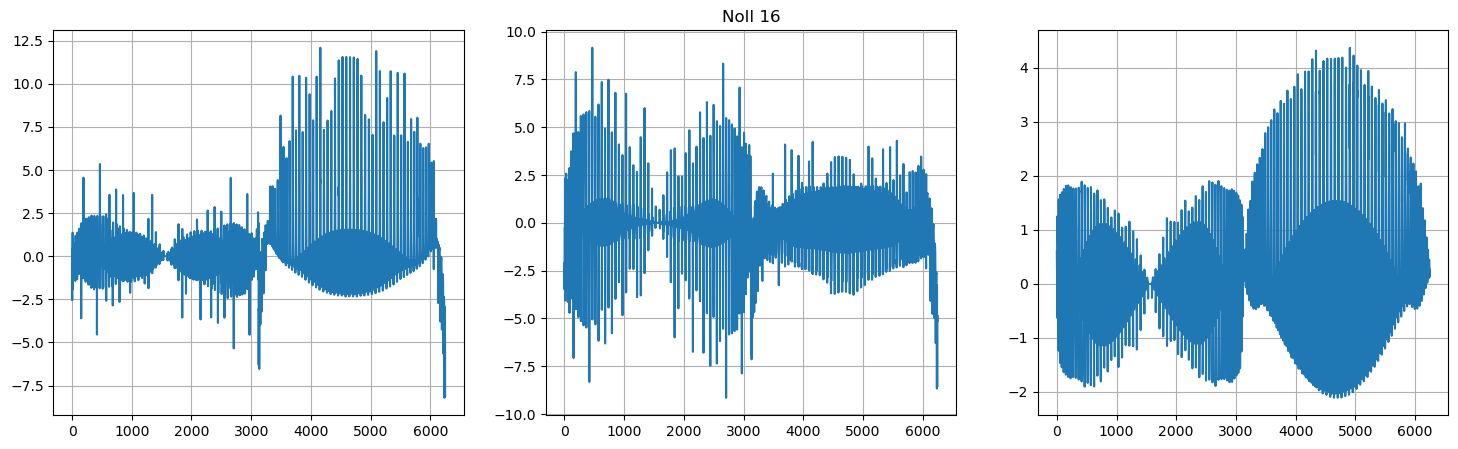

In [15]:
N = 5
Nmodes = int((N+1)*N/2)

method='slopes'
# method='diagonal_slopes'
# method='raw_intensity'

wfs.set_modulation_angle(3)

RecPP,IMpp = push_pull_calibrate(Nmodes, method=method)

In [ ]:
# Linearity check
Nmodes = 8
wfs.set_modulation_angle(3.0)
print(wfs.modulationAngleInLambdaOverD)
amp_vec = xp.linspace(-6,6,27,endpoint=True)

plt.figure()
plt.plot(amp_vec,amp_vec,'--')

intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        # output_intensity = wfs.modulate(zern, alpha, pix2rad)
        # slopes = ccd.compute_slopes(output_intensity, use_diagonal=useDiag)
        slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None, method=method)
        output_intensity = ccd.last_frame
        zern_reconstructed = RecPP @ slopes

        meas_amp[k] = zern_reconstructed[j]
    
    intensities[j,:,:] = output_intensity

    plt.plot(amp_vec, meas_amp,'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response\nModulation = 3 $\lambda$/D')
    plt.grid(True)

In [ ]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(toccd(intensities[i,:,:],ccd.detector_shape),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')

In [ ]:
mod0_RecPP,mod0_IMpp = push_pull_calibrate(Nmodes=15, method=method, amp=0.02)

In [ ]:
# Linearity check
Nmodes = 5
wfs.set_modulation_angle(0.0)
amp_vec = xp.linspace(-1,1,27,endpoint=True)

plt.figure()
plt.plot(amp_vec,amp_vec,'--')

intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        # output_intensity = wfs.modulate(zern, alpha, pix2rad)
        # slopes = ccd.compute_slopes(output_intensity, use_diagonal=useDiag)
        slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None, method=method)
        output_intensity = ccd.last_frame
        zern_reconstructed = mod0_RecPP @ slopes

        meas_amp[k] = zern_reconstructed[j]
    
    intensities[j,:,:] = output_intensity

    plt.plot(amp_vec, meas_amp,'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude [rad]')
    plt.ylabel('Measured amplitude [rad]')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)

In [ ]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(toccd(intensities[i,:,:],ccd.detector_shape),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')